<a href="https://colab.research.google.com/github/deepakjayakumar/TensorFlow_project_1/blob/main/god_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
#!unzip "drive/MyDrive/Dog Vision/dog-breed-identification.zip" -d "drive/MyDrive/Dog Vision/"


Mounted at /content/drive


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')


## 1. Problem

Identifying the breed of the dog in the giiven photo

## 2. Data

The data was taken from Kaggle dog breed database

https://www.kaggle.com/c/dog-breed-identification/data

## 3. Evaluation

The evealuation is a file with prediction probabilities of each dog breed of each test image

## 4. Features

Some information about the data:
* We are dealing with images (unstructured data) so its probabaly best we use deep learning
* There are 120 breeds of dog (Multi class classification)
* There are 10,000+ images in train set (these images have labels)
* There are 10,000+ images in the test set (these images dont have labels and we will want to predict it)

In [3]:
# Unzip the uploaded data in Google cloud
#!unzip "drive/MyDrive/Dog Vision/dog-breed-identification.zip" -d "drive/MyDrive/Dog Vision/"

### Get your workspace ready

In [4]:
# Import tensorflow in colab
import tensorflow as tf
print('Tensor version: ',tf.__version__)

Tensor version:  2.17.0


In [5]:
import tensorflow_hub as hub
print("TF hub version : ", hub.__version__)

# Check for GPU availability
print("GPU"," availabile" if tf.config.list_physical_devices("GPU") else "not available")

TF hub version :  0.16.1
GPU  availabile


# Getting our data ready

With all machine learning models our data should be in numeric. So we will be turining our images into tensors (numerical representation)

Lets start by acccesing our data anc checking out the labels

In [6]:
# check out the data of our labels
import pandas as pd
labels_csv = pd.read_csv("drive/MyDrive/Dog Vision/labels.csv")

In [7]:
# from google.colab import drive
# drive.mount('/content/drive')

In [8]:
labels_csv.describe()

,id,breed
count,10222,10222
unique,10222,120
top,000bec180eb18c7604dcecc8fe0dba07,scottish_deerhound
freq,1,126


In [9]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


<Axes: xlabel='breed'>

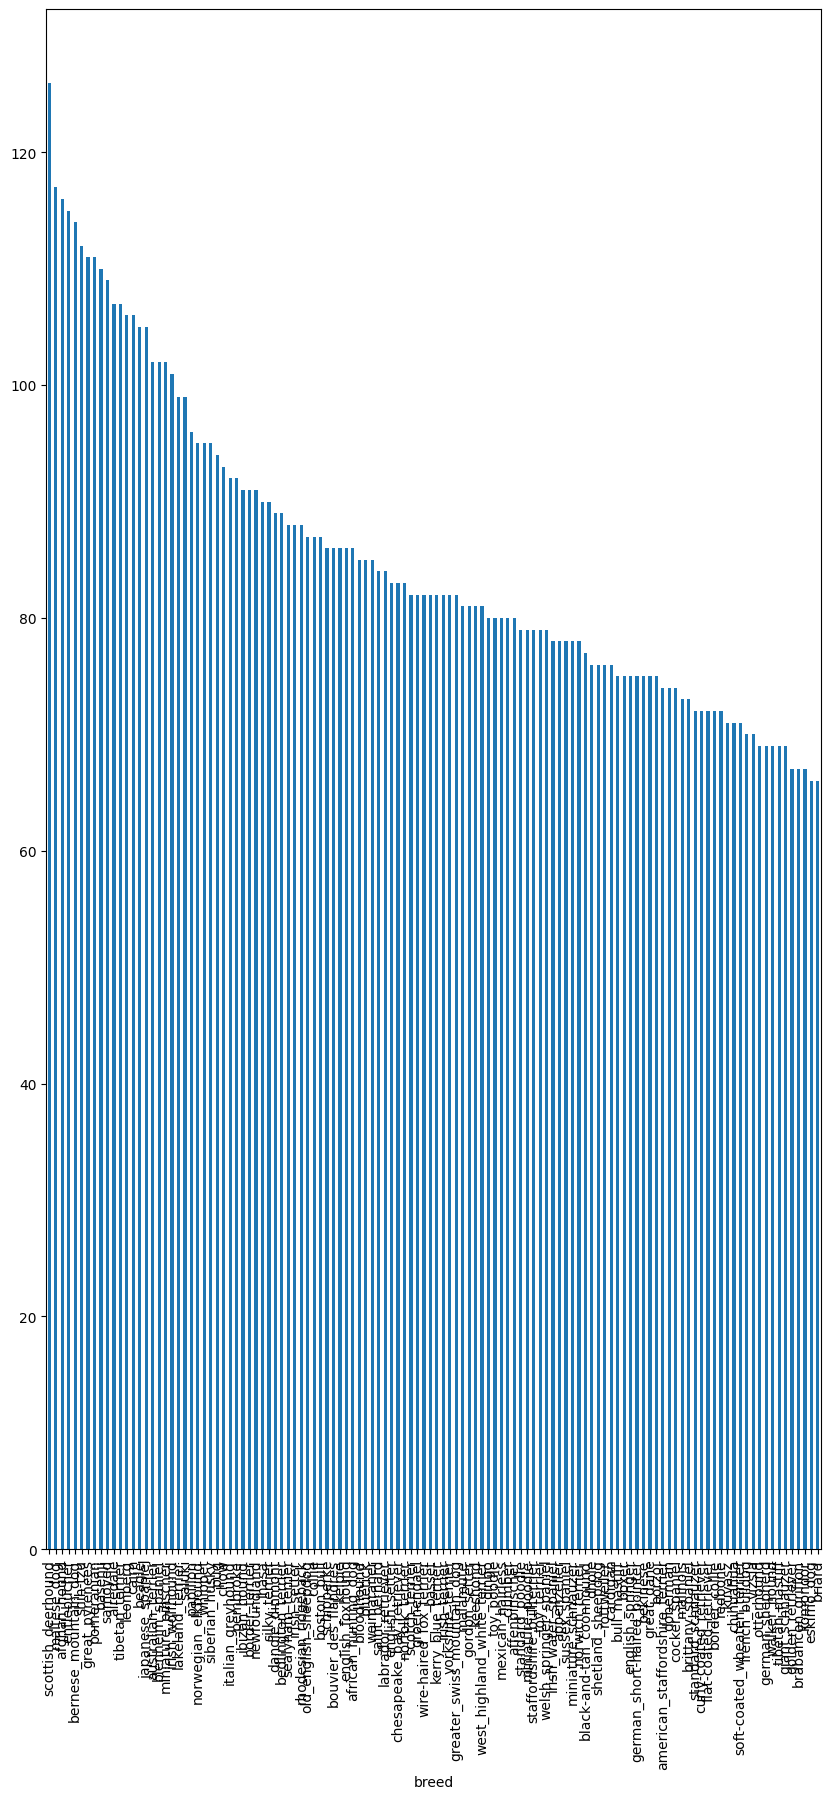

In [10]:
# How many counts are there with each breed?

labels_csv["breed"].value_counts().plot.bar(figsize=(10,20))

In [11]:
labels_csv["breed"].value_counts().median()

82.0

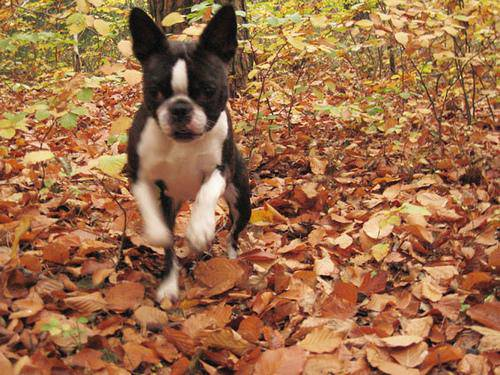

In [12]:
# Lets view an image
from IPython.display import Image
Image("drive/MyDrive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg")

### Getting images and their labels

Lets get a list of all our images file pathname

In [13]:
# Create file pathnames from Image ID's

# filenames = [fname for fname in labels_csv["id"].values]
filenames = ["drive/MyDrive/Dog Vision/train/" + fname + ".jpg" for fname in labels_csv["id"].values]
#filenames


In [14]:
#Check whether number of file names matches with number of Images
import os
if len(os.listdir("drive/MyDrive/Dog Vision/train/")) == len(filenames):
  print("Number of file names matches the number of image files")

Number of file names matches the number of image files


In [15]:
len(os.listdir("drive/MyDrive/Dog Vision/train/"))

10222

In [16]:
len(filenames)

10222

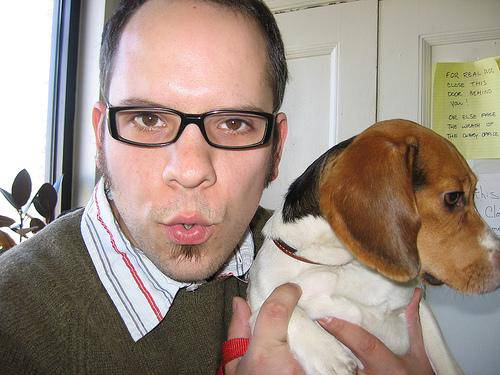

In [17]:
Image(filenames[8041])

Since we got our training file paths, lets prepare our labels

In [18]:
import numpy as np
labels = labels_csv["breed"]
labels = np.array(labels)
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [19]:
len(labels)

10222

In [20]:
# find the unique label values
unique_breeds  = np.unique(labels)
len(unique_breeds)

120

In [21]:
# Turn every label into boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [22]:
# Example : Turining boolean array into integers
print(labels[500]) #original Label
print(np.where(unique_breeds == labels[500])) # index where label occurs
print(boolean_labels[500].argmax()) # index where label occurs in boolean array
print(boolean_labels[500].astype(int)) # there will be a 1 where smaple label occurs

otterhound
(array([83]),)
83
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating our own validation set

Since the dataset from Kaggle doesnot contain the vaidation set we are creating it on our own

In [23]:
# Creating X and y variables
X = filenames
y = boolean_labels

In [24]:
len(X), len(y)

(10222, 10222)

We are going to start with -1000 images and increase when needed


In [25]:
# Set the number of images to be used for the experiment
NUM_IMAGES = 1000 #@param {type:"slider", min:1000,max:10000,step:100}

In [26]:
# Split our data into train and validation
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val = train_test_split(X[:NUM_IMAGES],y[:NUM_IMAGES],test_size=0.2,random_state=2)
len(X_train),len(X_val),len(y_train),len(y_val)

(800, 200, 800, 200)

In [27]:
# prompt: Lets have a geez at the training data

# Lets view an image
print(X_train[0])
Image(X_train[0])
Image(filenames[0])
print(y_train[0].astype(int))
print(unique_breeds[y_train[0].argmax()])


drive/MyDrive/Dog Vision/train/041d0d6a8d110b35a3795dd5c68f9a36.jpg
[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]
american_staffordshire_terrier


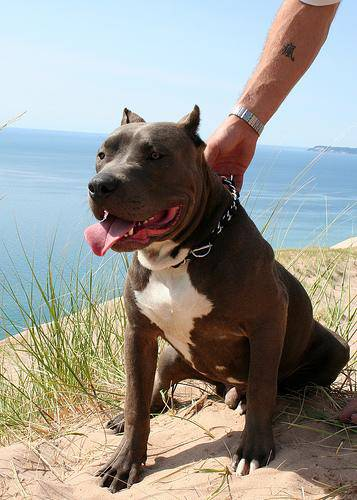

In [28]:
Image(X_train[0])

### Preprocessing the images

To preprocess our images into tensor we are going to write a function -
  1. Take an image file path as input
  2. Use tensorflow to read the file path and save it to a variable `image`
  3. Turn our `image` into tensor
  4. Resize the `image` to be a size of (200,200)
  5. Return the modified `image`


Before we do what import an `image` looks like

In [29]:
# Convert image to numpy array
from matplotlib.pyplot import imread
image = imread(filenames[900])
image.shape

(436, 500, 3)

In [30]:
image[:2]

array([[[ 49,  22,  11],
        [ 43,  16,   5],
        [ 43,  16,   5],
        ...,
        [121, 130, 129],
        [120, 129, 128],
        [119, 128, 127]],

       [[ 52,  25,  14],
        [ 48,  21,  10],
        [ 49,  22,  11],
        ...,
        [123, 132, 131],
        [123, 132, 131],
        [122, 131, 130]]], dtype=uint8)

In [31]:
#turn image into tensor
tf.constant(image)

<tf.Tensor: shape=(436, 500, 3), dtype=uint8, numpy=
array([[[ 49,  22,  11],
        [ 43,  16,   5],
        [ 43,  16,   5],
        ...,
        [121, 130, 129],
        [120, 129, 128],
        [119, 128, 127]],

       [[ 52,  25,  14],
        [ 48,  21,  10],
        [ 49,  22,  11],
        ...,
        [123, 132, 131],
        [123, 132, 131],
        [122, 131, 130]],

       [[ 47,  20,   9],
        [ 45,  18,   7],
        [ 46,  19,   8],
        ...,
        [124, 130, 130],
        [124, 130, 130],
        [124, 130, 130]],

       ...,

       [[199, 207, 220],
        [207, 217, 229],
        [201, 211, 223],
        ...,
        [ 28,  30,  25],
        [ 28,  30,  25],
        [ 27,  29,  24]],

       [[199, 207, 220],
        [207, 217, 229],
        [201, 211, 223],
        ...,
        [ 33,  35,  30],
        [ 32,  34,  29],
        [ 31,  33,  28]],

       [[199, 207, 220],
        [207, 217, 229],
        [201, 211, 223],
        ...,
        [ 36,  38,  3

In [32]:
# Define Image size
IMG_SIZE = 224

# create a function for preprocessing images
def process_image(image_path,img_size=  IMG_SIZE):
  """
  Takes an image file path and turns it into a tensor
  """
  #Read in an image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical tensor with 3 colour channels (Red,Green,Blue)
  image = tf.image.decode_jpeg(image,channels=3)
  # convert the color channel values from 0-255 to 0-1
  image = tf.image.convert_image_dtype(image,tf.float32)
  # resize the image to our desired size (244,244)
  image = tf.image.resize(image,size=[img_size,img_size])

  return image



In [33]:
tensor = tf.io.read_file(filenames[0])
tensor = tf.image.decode_jpeg(tensor,channels=3)
tensor = tf.image.convert_image_dtype(tensor,tf.float32)
tensor = tf.image.resize(tensor,size=[224,224])
tensor[:2]

<tf.Tensor: shape=(2, 224, 3), dtype=float32, numpy=
array([[[0.5705322 , 0.33588538, 0.15008473],
        [0.66901225, 0.4601166 , 0.26022965],
        [0.61062384, 0.43763596, 0.21601713],
        ...,
        [0.8182312 , 0.7297958 , 0.26963907],
        [0.72454786, 0.6059109 , 0.2653059 ],
        [0.7494603 , 0.6252918 , 0.32456532]],

       [[0.6761415 , 0.4733761 , 0.30642927],
        [0.5672121 , 0.38192675, 0.20349538],
        [0.5883547 , 0.4322571 , 0.2403155 ],
        ...,
        [0.9326942 , 0.8260503 , 0.41093278],
        [0.86072475, 0.74250627, 0.3694122 ],
        [0.76781666, 0.6461604 , 0.29291284]]], dtype=float32)>

In [34]:
process_image(filenames[2],img_size=  224)

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.3918853 , 0.3918853 , 0.36051273],
        [0.43775532, 0.43775532, 0.40638277],
        [0.44351017, 0.44351017, 0.41213763],
        ...,
        [0.05796662, 0.02239764, 0.01937653],
        [0.05252095, 0.0470589 , 0.04978992],
        [0.04586835, 0.05371149, 0.04978992]],

       [[0.38653433, 0.38261276, 0.3630049 ],
        [0.4161569 , 0.41223532, 0.39262748],
        [0.43315482, 0.42923325, 0.4096254 ],
        ...,
        [0.0909924 , 0.05177672, 0.04754004],
        [0.03035708, 0.02489503, 0.02762605],
        [0.02370449, 0.03154762, 0.02762605]],

       [[0.36859885, 0.36467728, 0.34506944],
        [0.35422263, 0.35030106, 0.33069322],
        [0.39899355, 0.39507198, 0.3754641 ],
        ...,
        [0.2361781 , 0.20233706, 0.19541305],
        [0.04896353, 0.04268564, 0.04582458],
        [0.04459034, 0.04705883, 0.04582458]],

       ...,

       [[0.7591447 , 0.75522316, 0.7356153 ],
        [0.74

## Turning our data into batches

Why turn data into batches?

Lets say you are trying to process 10000 images in one go, they might not fit into memory.

So thats why we use 32 at a time.

In order to use tensorflow effectively, we need our data in the form of tensor tuples which look like this :
`(image,label)`

In [35]:
# Create a simple function to return a tuple (image,label)
def get_image_label(image_path,label):
  """
  Take an image path name and the associated label,
  process an image and return a tuple of (image,label)
  """
  image = process_image(image_path)
  return image,label


In [36]:
#tensor = get_image_label
#tensor
(process_image(X[40]),tf.constant(y[40]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.99609005, 0.96119833, 0.95770377],
         [0.98501533, 0.94666374, 0.93379605],
         [0.99749774, 0.9770274 , 0.9565523 ],
         ...,
         [0.34569168, 0.5497533 , 0.22850783],
         [0.4276134 , 0.6322353 , 0.33483163],
         [0.36833197, 0.5772412 , 0.29097825]],
 
        [[0.9687435 , 0.965289  , 0.9172323 ],
         [0.94134724, 0.93233955, 0.8760108 ],
         [0.92182285, 0.9180851 , 0.8512452 ],
         ...,
         [0.36644298, 0.57037514, 0.24943131],
         [0.36225268, 0.5662274 , 0.2703323 ],
         [0.34930357, 0.5534058 , 0.27435333]],
 
        [[0.82989013, 0.87487435, 0.75133675],
         [0.7506709 , 0.7958162 , 0.66784185],
         [0.75523835, 0.8078179 , 0.67545015],
         ...,
         [0.40426058, 0.60512996, 0.2932135 ],
         [0.35947898, 0.55773896, 0.2682605 ],
         [0.38644102, 0.5856088 , 0.3115852 ]],
 
        ...,
 
        [[0.45484307, 0.5300532 

Now we've got a way to turn images into tuples of tensors

In [37]:
process_image(filenames[0],IMG_SIZE)

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.5705322 , 0.33588538, 0.15008473],
        [0.66901225, 0.4601166 , 0.26022965],
        [0.61062384, 0.43763596, 0.21601713],
        ...,
        [0.8182312 , 0.7297958 , 0.26963907],
        [0.72454786, 0.6059109 , 0.2653059 ],
        [0.7494603 , 0.6252918 , 0.32456532]],

       [[0.6761415 , 0.4733761 , 0.30642927],
        [0.5672121 , 0.38192675, 0.20349538],
        [0.5883547 , 0.4322571 , 0.2403155 ],
        ...,
        [0.9326942 , 0.8260503 , 0.41093278],
        [0.86072475, 0.74250627, 0.3694122 ],
        [0.76781666, 0.6461604 , 0.29291284]],

       [[0.46350825, 0.29595745, 0.1536156 ],
        [0.42554107, 0.27039403, 0.12009468],
        [0.7887875 , 0.6547362 , 0.49015   ],
        ...,
        [0.89372385, 0.7696401 , 0.41811958],
        [0.88609535, 0.7585918 , 0.36495727],
        [0.8243601 , 0.69494826, 0.2930575 ]],

       ...,

       [[0.7344025 , 0.4716574 , 0.2559711 ],
        [0.71

In [38]:
# Define a batch size, 32 is a good number
BATCH_SIZE = 32

# Create the function to turn data into batches
def create_data_batches(X,y=None,batch_size = BATCH_SIZE,valid_data=False,test_data=False ):
  """
  Create batches of data out of `Image` x and labels Y pairs.
  shuffle the data if it is training data but dont shuffle if it is validation data.
  Also accepts test data as input (no labels)
  """
  #If the data is test dat we dont have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) #only file paths no labels
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # If the data is valid dataset we dont need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y))) # both file path and labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print("Create training data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y))) # both file path and labels
    # shuffling images and labels before image processing is much quicker
    data = data.shuffle(buffer_size=len(X))
    #Create image label tuples, also turns the image path into preprocessed image
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch


In [39]:
# Create training and validation data batches
train_data = create_data_batches(X_train,y_train)
val_data = create_data_batches(X_val,y_val,valid_data= True)

Create training data batches...
Creating validation data batches...


In [40]:
# chck out the different attribute of our data batches
train_data.element_spec,val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing data batches

Our data are now in batches, so these can be hard to understand. We are now visualising it.

In [41]:
import matplotlib.pyplot as plt

# create a function to view images in the data batch
def show_25_images(images,labels):
  """
  Display a batch of 25 images and their labels from a data batch
  """

  # set up the figure
  plt.figure(figsize=(10,10))
  # loop through 25 for displaying 25 images
  for i in range(25):
    # create a subplot 5*5
    ax = plt.subplot(5,5,i+1)
    # display an image
    plt.imshow(images[i])
    # add the label
    plt.title(unique_breeds[labels[i].argmax()])
    #plot the axis off
    plt.axis("off")



In [42]:
train_images,train_labels = next(train_data.as_numpy_iterator())
train_images.shape,train_labels.shape


((32, 224, 224, 3), (32, 120))

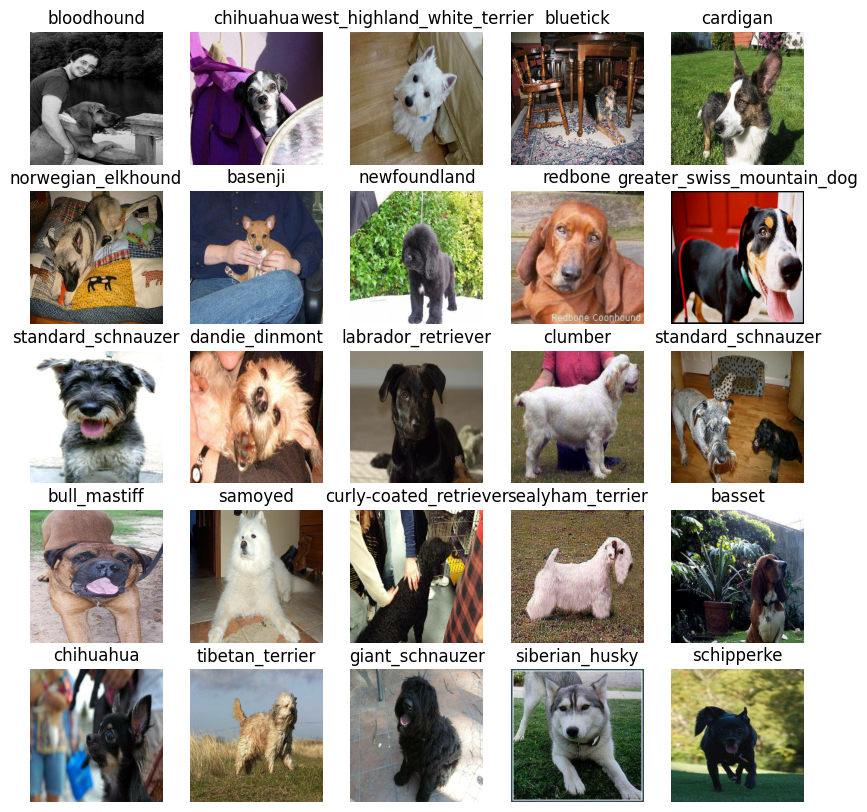

In [43]:
# Now lets visualize the data in a training batch

show_25_images(train_images,train_labels)

## Building a model

Before we build a model, there are few things we need to define :
* The input shape (our image shape in the form of tensor) to our model.
* The output shape (image labels, in the form of tensor) of our model.
* The URL of the model we want to use. it is form kaggle models - https://www.kaggle.com/models/google/mobilenet-v2/tensorFlow2/130-224-classification


In [44]:
# setup input shape to the model
INPUT_SHAPE = [None,IMG_SIZE,IMG_SIZE,3] # batch size, height,width,colour channels

# output shape of the model
OUTPUT_SHAPE = len(unique_breeds)

# SETup model URL from Tendorflow hub
MODEL_URL = "https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/130-224-classification/2"

Now we got our input and output models ready to go.
Lets put them together in a keras deep learning model.

Knowing this, lets create a function which:
* Takes the input shape, output shape and the model we have given as parameter.
* Defines the ayers in the Keras model in a sequential manner
* Compiles the model (it should be evaluated and improved)
* Builds the model ( tells the model the input shape)
* Returns the model

In [45]:
# Create a function which builds a Keras model
import tf_keras as tfk
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  hubs_layer = hub.KerasLayer(MODEL_URL)

    # Setup the model layers

  model = tfk.Sequential([hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
                          tfk.layers.Dense(units=OUTPUT_SHAPE,
                          activation="softmax") # Layer 2 (output layer)
                          ])

  # Compile the model
  model.compile(
      loss=tfk.losses.CategoricalCrossentropy(),
      optimizer=tfk.optimizers.Adam(),
      metrics=["accuracy"]
  )

  # Build the model
  model.build(INPUT_SHAPE)

  return model

In [46]:
model = create_model()
model.summary()

Building model with: https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/130-224-classification/2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 5552953 (21.18 MB)
Trainable params: 120240 (469.69 KB)
Non-trainable params: 5432713 (20.72 MB)
_________________________________________________________________


## Creating callback

callbacks are helper function a model can use durig training to do such things as save its progress, check its progress or stope traing early if the model stops improving.

We will create 2 callbacks, one for tensorboard which helpts track our model progress and another for early stopping which prevents our model from training too long

### TensorBoard Callback

To set up a tensorboard callback we need 3 things
1. Load tensorboard extension
2. Create a tensorboard callback which able to save logs and passs it to our model fit function
3. Visualize our models training logs with tensorboard magic function. we do this after model training

In [47]:
# Load TensorBoard Notebook extension
%load_ext tensorboard


In [48]:
import datetime

# Create a function to build a Tensorflow Callback
def create_tensorboard_callback():
  # create a log directory to store tensorboard logs
  logdir = os.path.join("drive/MyDrive/Dog Vision/logs",
                        # Make it so the logs get tracked when we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tfk.callbacks.TensorBoard(logdir)

### Early stopping callback

Early stopping helps dtop our model from overfeeding by stop training if certain evaluation metric stops improving - https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

In [50]:
# Create early stopping callback
early_stopping = tfk.callbacks.EarlyStopping(monitor= "val_accuracy",
                                             patience =3)

In [ ]:
#